In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import admix
import os
import pandas as pd
import numpy as np
import glob
import json
from scipy.interpolate import CubicSpline
from scipy import stats
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False

In [2]:
COMPILE_DATA = False
if COMPILE_DATA:
    !cp -r ../experiments/04-genome-wide-meta-analysis/results/raw data/Figure3/

In [3]:
for study in ["ukb", "page", "aou"]:
    print(f"In study {study}")
    admix.cli.meta_analyze_genet_cor(f"data/Figure3/{study}/*loglkl.txt")
    print("")

print("Overall:")
admix.cli.meta_analyze_genet_cor(f"data/Figure3/*/*loglkl.txt")

ukb_name_dict = {
    "244": "Hypothyroidism",
    "250.1": "Type 1 diabetes",
    "250.2": "Type 2 diabetes",
    "401": "Hypertension",
    "495": "Asthma",
    "cholesterol": "Total cholesterol",
    "diastolic_BP": "Diastolic blood pressure",
    "erythrocyte_width": "RBC distribution width",
    "erythrocyte": "RBC count",
    "ever_smoked": "Ever smoked",
    "height": "Height",
    "LDL": "LDL",
    "log_BMI": "BMI",
    "log_HbA1c": "HbA1c",
    "log_HDL": "HDL",
    "log_heel_BMD": "BMD",
    "log_HLR_reticulocyte": "HLR count",
    "log_leukocyte": "White blood cell count",
    "log_lymphocyte": "Lymphocyte count",
    "log_monocyte": "Monocyte count",
    "log_platelet": "Platelet count",
    "log_triglycerides": "Triglycerides",
    "MCH": "MCH",
    "neuroticism": "Neuroticism",
    "systolic_BP": "Systolic blood pressure",
    "years_of_edu": "Education years",
}
page_name_dict = {
    "crp": "C-reactive protein",
    "total_wbc_cnt": "White blood cell count",
    "mean_corp_hgb_conc": "MCHC",
    "platelet_cnt": "Platelet count",
    "hdl": "HDL",
    "ldl": "LDL",
    "triglycerides": "Triglycerides",
    "total_cholesterol": "Total cholesterol",
    "cigs_per_day_excl_nonsmk_updated": "Cigarettes per day",
    "coffee_cup_day": "Coffee consumption",
    "a1c": "HbA1c",
    "insulin": "Fasting insulin",
    "glucose": "Fasting glucose",
    "t2d_status": "Type 2 diabetes",
    "qt_interval": "QT interval",
    "qrs_interval": "QRS interval",
    "pr_interval": "PR interval",
    "systolic_bp": "Systolic blood pressure",
    "diastolic_bp": "Diastolic blood pressure",
    "hypertension": "Hypertension",
    "waist_hip_ratio": "WHR",
    "height": "Height",
    "bmi": "BMI",
    "egfrckdepi": "eGFR",
}
aou_name_dict = {
    "bmi": "BMI",
    "diastolic_blood_pressure": "Diastolic blood pressure",
    "systolic_blood_pressure": "Systolic blood pressure",
    "HDL": "HDL",
    "LDL": "LDL",
    "heart_rate": "Heart rate",
    "height": "Height",
    "TC": "Total cholesterol",
    "TG": "Triglycerides",
    "waist_hip_ratio": "WHR",
}

In study ukb
Meta-analysis results across 26 files
-------------------------------------
rg mode  = 0.981
50% HPDI = [0.964, 0.996]
95% HPDI = [0.912, 1]
Null (rg = 1) p-value: 0.549

In study page
Meta-analysis results across 24 files
-------------------------------------
rg mode  = 0.902
50% HPDI = [0.887, 0.916]
95% HPDI = [0.854, 0.943]
Null (rg = 1) p-value: 1.337e-07

In study aou
Meta-analysis results across 10 files
-------------------------------------
rg mode  = 0.971
50% HPDI = [0.961, 0.98]
95% HPDI = [0.943, 0.997]
Null (rg = 1) p-value: 0.04581

Overall:
Meta-analysis results across 60 files
-------------------------------------
rg mode  = 0.947
50% HPDI = [0.94, 0.954]
95% HPDI = [0.925, 0.969]
Null (rg = 1) p-value: 8.689e-07


In [4]:
# number of individuals per trait
dense_rg_list = np.linspace(0, 1, 1001)
rg_list = None
dict_nindiv = {}
# loglikelihood curve per trait (agg across studies)
dict_loglik = {}

for study in ["ukb", "page", "aou"]:
    file_list = glob.glob(f"data/Figure3/{study}/*.summary.json")
    dict_name = {"ukb": ukb_name_dict, "page": page_name_dict, "aou": aou_name_dict}[
        study
    ]

    for f in file_list:
        with open(f) as fh:
            data = json.load(fh)
        trait_id = f.split("/")[-1][: -len(".summary.json")]
        trait_name = dict_name[trait_id]
        if trait_name not in dict_nindiv:
            dict_nindiv[trait_name] = []
        dict_nindiv[trait_name].append(data["n"])

        df_loglkl = pd.read_csv(f"data/Figure3/{study}/{trait_id}.loglkl.txt", sep="\t")
        if rg_list is None:
            rg_list = df_loglkl["rg"].values
        else:
            assert np.all(rg_list == df_loglkl["rg"].values)
        if trait_name not in dict_loglik:
            dict_loglik[trait_name] = 0
        dict_loglik[trait_name] += CubicSpline(rg_list, df_loglkl["loglkl"].values)(
            dense_rg_list
        )

assert list(dict_nindiv.keys()) == list(dict_loglik.keys())

In [5]:
df_tbl_trait = []

for trait in dict_loglik:
    loglik = dict_loglik[trait]
    mode = dense_rg_list[loglik.argmax()]
    hdpi = admix.data.hdi(dense_rg_list, loglik, ci=0.95)
    if isinstance(hdpi, tuple):
        hdpi = f"[{hdpi[0]:.2f}, {hdpi[1]:.2f}]"
    elif isinstance(hdpi, list):
        hdpi = " ".join([f"[{i[0]:.2f}, {i[1]:.2f}]" for i in hdpi])
    pval = stats.chi2.sf((loglik.max() - loglik[-1]) * 2, df=1)
    df_tbl_trait.append(
        [
            trait,
            np.sum(dict_nindiv[trait]),
            mode,
            hdpi,
            f"{pval:.2g}",
        ]
    )

df_tbl_trait = (
    pd.DataFrame(
        df_tbl_trait,
        columns=[
            "Trait",
            "N",
            "Mode",
            "95% credible interval(s)",
            "p-value",
        ],
    )
    .sort_values("N")
    .reset_index(drop=True)
).set_index("Trait")

In [6]:
plot_trait_list = list(
    df_tbl_trait.sort_values("N", ascending=False).iloc[0:13].index.values
) + ["C-reactive protein", "MCH", "RBC count"]

df_plot = df_tbl_trait.loc[plot_trait_list, :].sort_values("N")
df_plot["display"] = df_plot.apply(
    lambda row: f"{row.name} ({int(np.round(row.N / 1000))}K)", axis=1
)
df_plot.loc["C-reactive protein", "display"] = df_plot.loc[
    "C-reactive protein", "display"
].replace("C-reactive protein", "CRP")
df_plot.loc["Total cholesterol", "display"] = df_plot.loc[
    "Total cholesterol", "display"
].replace("Total cholesterol", "TC")

dict_plot = {row.display: dict_loglik[row.name] for _, row in df_plot.iterrows()}
dict_plot["Meta-analysis (60 study-trait)"] = np.sum(list(dict_loglik.values()), axis=0)

# Panel a-b

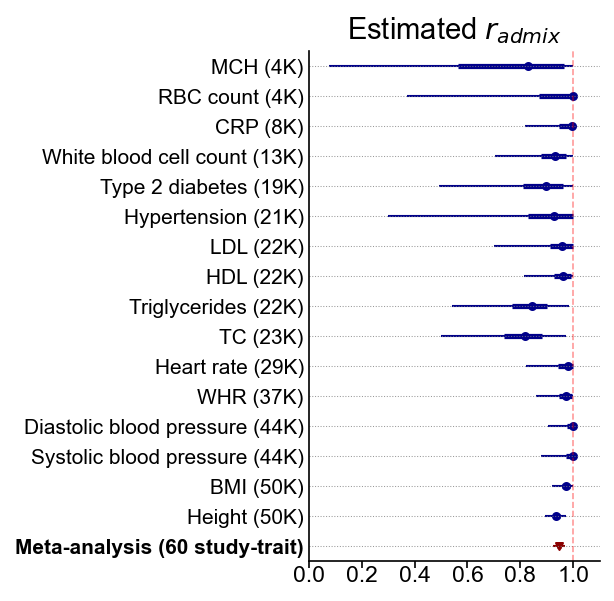

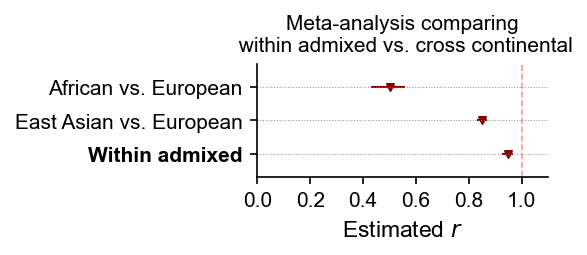

In [7]:
################################
####### within admixed #########
################################
fig, ax = plt.subplots(figsize=(2.5, 4.5), dpi=150)

admix.plot.rg_posterior(
    dense_rg_list,
    dict_plot,
    colors=["darkblue"] * (len(dict_plot) - 1) + ["darkred"],
    markers=["o"] * (len(dict_plot) - 1) + ["v"],
    ax=ax,
)
ax.set_title(ax.get_title(), fontsize=14)
# set color for the meta-analysis
# ax.get_yticklabels()[0].set_color("darkred")
ax.get_yticklabels()[0].set_weight("bold")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(ax.get_xticks(), fontsize=11)
ax.set_xlabel(None)

plt.savefig("out/Figure3a.pdf", bbox_inches="tight")
plt.show()
################################
#### continental comparison ####
################################

fig, ax = plt.subplots(figsize=(2.5, 1), dpi=150)
ax.axvline(x=1.0, color="red", ls="--", lw=0.8, alpha=0.4)
df_data = pd.DataFrame(
    {
        "label": [
            r"Within admixed",
            r"East Asian vs. European",
            r"African vs. European",
        ],
        "center": [0.947, 0.85, 0.50],
        "lower": [0.925, 0.83, 0.43],
        "higher": [0.969, 0.87, 0.56],
    }
)

ax.scatter(
    y=np.arange(len(df_data)), x=df_data["center"], s=11, color="darkred", marker="v"
)
errbars = ax.errorbar(
    y=np.arange(len(df_data)),
    x=df_data["center"],
    xerr=(df_data["center"] - df_data["lower"], df_data["higher"] - df_data["center"]),
    fmt=" ",
    lw=1.0,
    ecolor="darkred",
)
# ax.get_yticklabels()[0].set_color("darkred")
ax.get_yticklabels()[0].set_weight("bold")

ax.set_yticks(np.arange(df_data.shape[0]))
ax.set_yticklabels(df_data.label, fontsize=10)
ax.set_xlim(0, 1.1)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.set_ylim(-0.7, 2.7)
ax.set_title(
    "Meta-analysis comparing\n within admixed vs. cross continental", fontsize=10
)

for y in np.arange(3):
    ax.axhline(y=y, color="gray", ls="dotted", lw=0.5, alpha=0.8)

ax.set_xlabel("Estimated $r$", fontsize=11)
plt.savefig("out/Figure3b.pdf", bbox_inches="tight")
plt.show()

# Panel c

In [8]:
df_assoc = pd.read_excel(
    "https://www.medrxiv.org/content/medrxiv/early/2022/08/18/2022.08.16.22278868/DC1/embed/media-1.xlsx?download=true",
    sheet_name=1,
).rename(columns={"HET p-value": "HET_P"})
df_assoc.loc[:, "bonferroni_significant"] = df_assoc["HET_P"] < 0.05 / len(df_assoc)

In [9]:
def report_assoc(df_assoc, direction="AFR~EUR"):

    deming_list = []
    ols_list = []
    pearsonr_list = []

    def deming_slope(df, direction):
        assert direction in ["AFR~EUR", "EUR~AFR"]
        if direction == "AFR~EUR":
            return admix.data.deming_regression(
                x=df["EUR_BETA"],
                y=df["AFR_BETA"],
                sx=df["EUR_SE"],
                sy=df["AFR_SE"],
            )[0]
        else:
            return admix.data.deming_regression(
                x=df["AFR_BETA"],
                y=df["EUR_BETA"],
                sx=df["AFR_SE"],
                sy=df["EUR_SE"],
            )[0]

    def ols_slope(df, direction):
        assert direction in ["AFR~EUR", "EUR~AFR"]
        if direction == "AFR~EUR":
            return linregress(x=df["EUR_BETA"], y=df["AFR_BETA"])[0]
        else:
            return linregress(x=df["AFR_BETA"], y=df["EUR_BETA"])[0]

    for _ in range(1000):
        df_tmp = df_assoc.sample(len(df_assoc), replace=True)
        deming_list.append(deming_slope(df_tmp, direction))
        ols_list.append(ols_slope(df_tmp, direction))
        pearsonr_list.append(pearsonr(df_tmp.EUR_BETA, df_tmp.AFR_BETA)[0])

    deming = deming_slope(df_assoc, direction)
    ols = ols_slope(df_assoc, direction)
    lgc, lgc_ci = admix.data.lambda_gc(df_assoc.HET_P, bootstrap_ci=True)

    print(f"{len(df_assoc)} SNPs")
    print(
        f"Pearson's r = {stats.pearsonr(df_assoc.EUR_BETA, df_assoc.AFR_BETA)[0]:.2g}, SE={np.std(pearsonr_list):.2f}"
    )
    print(
        f"Deming regression slope: {deming:.2f}. Bootstrap mean (se): {np.mean(deming_list):.2f} ({np.std(deming_list):.2f})"
    )
    print(
        f"OLS regression slope: {ols:.2f}. Bootstrap mean (se): {np.mean(ols_list):.2f} ({np.std(ols_list):.2f})"
    )
    print(f"lambda gc = {lgc:.2f}, ci=[{lgc_ci[0]:.2f}, {lgc_ci[1]:.2f}]")

In [10]:
np.random.seed(1234)
mch_chr16_snps = df_assoc.trait.isin(["MCH"]) & (df_assoc.chrom == 16)
for direction in ["AFR~EUR", "EUR~AFR"]:
    print(f"## {direction}")
    print("# all SNPs")
    report_assoc(df_assoc, direction)
    print("")
    print("# SNPs removing MCH")
    report_assoc(df_assoc[~mch_chr16_snps], direction)
    print("")

## AFR~EUR
# all SNPs
217 SNPs
Pearson's r = 0.73, SE=0.04
Deming regression slope: 1.22. Bootstrap mean (se): 1.22 (0.08)
OLS regression slope: 0.83. Bootstrap mean (se): 0.83 (0.05)
lambda gc = 4.92, ci=[3.39, 7.34]

# SNPs removing MCH
193 SNPs
Pearson's r = 0.85, SE=0.02
Deming regression slope: 1.08. Bootstrap mean (se): 1.08 (0.05)
OLS regression slope: 0.92. Bootstrap mean (se): 0.92 (0.06)
lambda gc = 3.94, ci=[3.33, 6.27]

## EUR~AFR
# all SNPs
217 SNPs
Pearson's r = 0.73, SE=0.04
Deming regression slope: 0.82. Bootstrap mean (se): 0.82 (0.06)
OLS regression slope: 0.64. Bootstrap mean (se): 0.64 (0.06)
lambda gc = 4.92, ci=[3.39, 7.34]

# SNPs removing MCH
193 SNPs
Pearson's r = 0.85, SE=0.03
Deming regression slope: 0.93. Bootstrap mean (se): 0.93 (0.04)
OLS regression slope: 0.79. Bootstrap mean (se): 0.80 (0.06)
lambda gc = 3.94, ci=[3.23, 5.83]



In [11]:
df_plot = df_assoc.copy()

In [12]:
cmap = plt.get_cmap("Set1")
colors = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02"]
dict_color = dict()
signif_trait_list = (
    df_plot.loc[df_plot.bonferroni_significant]
    .groupby("trait")
    .apply(lambda df: np.log10(df["HET_P"]).mean())
    .sort_values()
    .index.values
)
for i, trait in enumerate(signif_trait_list):
    # dict_color[trait] = cmap(i)
    dict_color[trait] = colors[i]
dict_trait_name = {t: t for t in signif_trait_list}
dict_trait_name["C-reactive protein"] = "CRP"
dict_trait_name["Total cholesterol"] = "TC"

In [13]:
df_plot["color"] = df_plot.apply(
    lambda x: dict_color[x.trait] if x.bonferroni_significant else "black", axis=1
)

In [14]:
def plot_slope_range(slope, range1, range2, color, ax, lw=1, ls="--"):
    xlim = np.array(ax.get_xlim())
    line = ax.axline((0, 0), slope=slope, color=color, lw=lw, ls=ls)
    shade = ax.fill_between(
        xlim, xlim * range1, xlim * range2, color=color, alpha=0.1, edgecolor=None
    )
    return line, shade

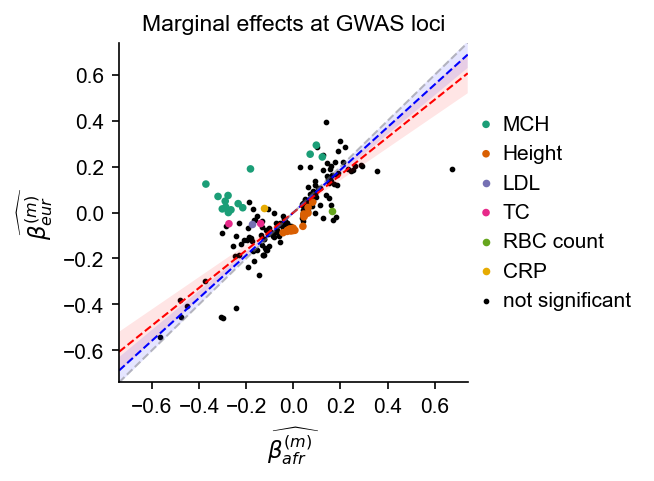

In [15]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)

# bonferroni significant
df_tmp = df_plot[df_plot.bonferroni_significant]
assert set(df_tmp.trait) == set(dict_trait_name.keys())
for trait in dict_trait_name:
    df = df_tmp[df_tmp.trait == trait]
    ax.scatter(
        df["AFR_BETA"],
        df["EUR_BETA"],
        s=7,
        color=df["color"],
        label=dict_trait_name[trait],
    )

# background
df_tmp = df_plot[~df_plot.bonferroni_significant]
ax.scatter(
    df_tmp["AFR_BETA"],
    df_tmp["EUR_BETA"],
    s=3,
    color="black",
    label="not significant",
    zorder=-1,
)

ax.set_xlabel("$\\widehat{\\beta_{afr}^{(m)}}$", fontsize=11)
ax.set_ylabel("$\\widehat{\\beta_{eur}^{(m)}}$", fontsize=11)
lim = df_plot[["AFR_BETA", "EUR_BETA"]].abs().max().max() * 1.1
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks(np.linspace(-0.6, 0.6, 7))
ax.set_yticks(np.linspace(-0.6, 0.6, 7))

if True:
    # slope 1
    slope_estimate = 0.93
    slope_se = 0.04

    slope_line, slope_shade = plot_slope_range(
        slope_estimate,
        slope_estimate - slope_se * 1.96,
        slope_estimate + slope_se * 1.96,
        color="blue",
        ax=ax,
    )


if True:
    # slope 2
    slope_estimate = 0.82
    slope_se = 0.06

    slope_line, slope_shade = plot_slope_range(
        slope_estimate,
        slope_estimate - slope_se * 1.96,
        slope_estimate + slope_se * 1.96,
        color="red",
        ax=ax,
    )

# dots legend
ax.axline((0, 0), slope=1, color="gray", ls="--", lw=1.0, alpha=0.5)
ax.legend(
    bbox_to_anchor=(1.23, 0.5),
    loc="center",
    frameon=False,
    handletextpad=-0.2,
)

ax.set_title("Marginal effects at GWAS loci", fontsize=11)
fig.savefig("out/Figure3c.pdf", bbox_inches="tight")